## From the article

# Implementing a distance-based classifier with a quantum interference circuit

###  M. Schuld et al 2017 EPL 119 60002

## Let's try to input more training vectors from the Iris Data Set

# Preparing the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv("Iris/iris.data",header=None,names=["f0","f1","f2","f3","class"])

In [4]:
setosa = iris[iris["class"] == "Iris-setosa"]
# setosa.loc[:,"class"] = -1
setosa.loc[:,"color"] = "Green"

In [5]:
versicolor = iris[iris["class"] == "Iris-versicolor"]
# versicolor.loc[:,"class"] = 1
versicolor.loc[:,"color"] = "Blue"

In [6]:
virginica = iris[iris["class"] == "Iris-virginica"]
# virginica.loc[:,"class"] = 1
virginica.loc[:,"color"] = "Red"

In [7]:
data = pd.concat([setosa,versicolor,virginica])

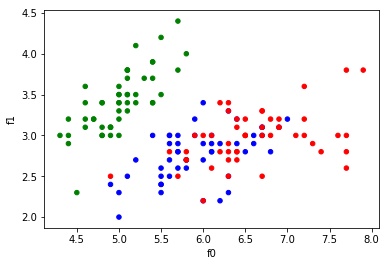

In [9]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [10]:
data.loc[:,["f0","f1","f2","f3"]].describe()

,f0,f1,f2,f3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
# data.mean()
# data["f0"] -= data.mean()[0]
# data["f1"] -= data.mean()[1]

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.loc[:,["f0","f1","f2","f3"]] = scaler.fit_transform(data.loc[:,["f0","f1","f2","f3"]])

In [12]:
data.loc[:,["f0","f1","f2","f3"]].describe()

,f0,f1,f2,f3
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-2.775558e-16,-5.140333e-16,1.154632e-16,9.251859e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.438987e+00,-1.568735e+00,-1.444450e+00
25%,-9.006812e-01,-5.877635e-01,-1.227541e+00,-1.181504e+00
50%,-5.250608e-02,-1.249576e-01,3.362659e-01,1.332259e-01
75%,6.745011e-01,5.692513e-01,7.627586e-01,7.905908e-01
max,2.492019e+00,3.114684e+00,1.786341e+00,1.710902e+00


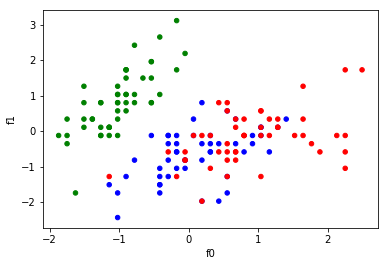

In [13]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [14]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [15]:
for i in data.index:
    v = [data["f0"][i],data["f1"][i],data["f2"][i],data["f3"][i]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"], data.loc[i,"f2"], data.loc[i,"f3"] = v[0], v[1], v[2], v[3]

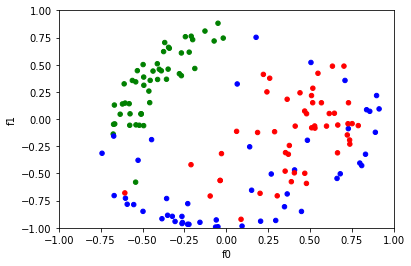

In [16]:
data.plot.scatter(x="f0", y="f1", c=data.color, xlim=(-1,1), ylim=(-1,1))

In [18]:
setosa = data[data["class"]=="Iris-setosa"]

In [19]:
versicolor = data[data["class"]=="Iris-versicolor"]

In [20]:
virginica = data[data["class"]=="Iris-virginica"]

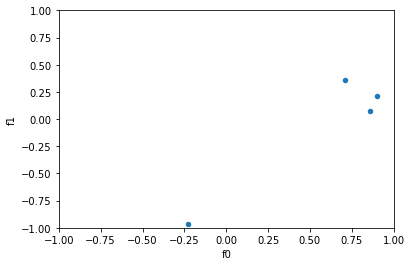

In [21]:
versicolor.iloc[0:4].plot.scatter(x="f0", y="f1", xlim=(-1,1), ylim=(-1,1))
# It is a good move to include the fourth point, lower in the plot

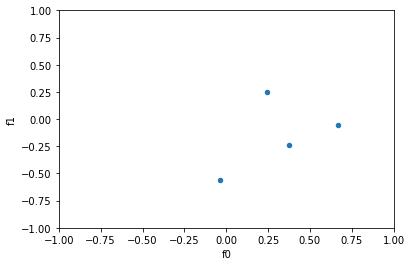

In [22]:
virginica.iloc[0:4].plot.scatter(x="f0", y="f1", xlim=(-1,1), ylim=(-1,1))

In [ ]:
# f0 = data.columns.get_loc("f0")
# f3 = data.columns.get_loc("f3")

In [23]:
T0 = setosa.iloc[0:2].loc[:,"f0":"f3"].apply(np.arcsin)
T0

,f0,f1,f2,f3
0,-0.398045,0.460232,-0.615332,-0.600497
1,-0.546013,-0.056800,-0.655245,-0.639131


In [24]:
T1 = versicolor.iloc[0:2].loc[:,"f0":"f3"].apply(np.arcsin)
T1 = T1.append(versicolor.iloc[3:4].loc[:,"f0":"f3"].apply(np.arcsin))
T1

,f0,f1,f2,f3
50,1.115542,0.218237,0.350153,0.170455
51,0.788796,0.363322,0.459435,0.429847
53,-0.232717,-1.314159,0.076153,0.073923


In [25]:
T2 = virginica.iloc[0:3].loc[:,"f0":"f3"].apply(np.arcsin)
T2

,f0,f1,f2,f3
100,0.245536,0.252752,0.594269,0.850469
101,-0.036191,-0.599828,0.553454,0.688538
102,0.729347,-0.054714,0.562032,0.545221


In [26]:
Se = setosa.loc[:,"f0":"f3"].apply(np.arcsin)

In [27]:
Ve = versicolor.loc[:,"f0":"f3"].apply(np.arcsin)

In [28]:
Vi = virginica.loc[:,"f0":"f3"].apply(np.arcsin)

# Building the quantum circuit

To store 4 features I need 2 $i$ qubits.  
To store 3 classes I need 2 $c$ quibits.  
To store 6 training vectors I need 3 $m$ qubits.  
I need some ancilla qubits for the QRAM routine.  
I need one more bit to store the conditional measurement on the rotation qubit. 

In [29]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
import qiskit.aqua.circuits.gates.controlled_ry_gates

In [30]:
def encodeVector(circuit,data,i,controls,rotationQubit,ancillaQubits):
    # |00>
    circuit.x(i)
    circuit.mcry(data[0],controls,rotationQubit,ancillaQubits)
    circuit.x(i)
    
    # |01>
    circuit.x(i[1])
    circuit.mcry(data[1],controls,rotationQubit,ancillaQubits)
    circuit.x(i[1])
    
    # |10>
    circuit.x(i[0])
    circuit.mcry(data[2],controls,rotationQubit,ancillaQubits)
    circuit.x(i[0])
    
    # |11>
    circuit.mcry(data[3],controls,rotationQubit,ancillaQubits)

In [31]:
def encodeClass(circuit,irisClass):
    classSwitcher = {
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica": 2
    }
    # header = footer
    if classSwitcher.get(irisClass) == 0:
        circuit.x(c)
    elif classSwitcher.get(irisClass) == 1:
        circuit.x(c[1])
    elif classSwitcher.get(irisClass) == 2:
        circuit.x(c[0])

In [32]:
def encodeIndex3(circuit,index):
    """
    Encode the index of the training vectors with three qubits
    """
    
    # header = footer
    if index == 0: # |000>
        circuit.x(m)
    elif index == 1: # |001>
        circuit.x(m[1])
        circuit.x(m[2])
    elif index == 2: # |010>
        circuit.x(m[0])
        circuit.x(m[2])
    elif index == 3: # |011>
        circuit.x(m[2])
    elif index == 4: # |100>
        circuit.x(m[0])
        circuit.x(m[1])
    elif index == 5: # |101>
        circuit.x(m[1])
    elif index == 6: # |110>
        circuit.x(m[0])
    elif index == 7: # |111>
        None

In [33]:
def encodeTraining(circuit,data,i,controls,rotationQubit,ancillaQubits,c,m):
    # Header
    encodeClass(circuit,c)
    encodeIndex3(circuit,m)
    
    # Encoder
    encodeVector(circuit,data,i,controls,rotationQubit,ancillaQubits)
    
    # Footer
    encodeClass(circuit,c)
    encodeIndex3(circuit,m)

In [34]:
a = QuantumRegister(1,'a') # knn ancilla
m = QuantumRegister(3,'m') # training vector index
i = QuantumRegister(2,'i') # feature index
r = QuantumRegister(1,'r') # rotation qubit
q = QuantumRegister(6,'q') # qram ancilla
c = QuantumRegister(2,'c') # class
b = ClassicalRegister(4, 'bit')
circuit = QuantumCircuit(a,m,i,r,q,c,b)

circuit.h(a)
circuit.h(m)
circuit.h(i)
circuit.h(c)

# circuit.cry(theta, control, target)
# circuit.mcry(theta, controls, target, ancillae)

# >>> Encode the input vector >>>

encodeVector(circuit,Se.iloc[16],i,a[:]+i[:],r[0],q)

circuit.x(a)

# <<< Encode the input vector <<<

# >>> Encode the first training vector >>>

# |c> = |00>
# |m> = |000>

encodeTraining(circuit,T0.iloc[0],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T0.iloc[0].name,"class"],0)

# <<< Encode the first training vector <<<

# >>> Encode the second training vector >>>

# |c> = |00>
# |m> = |001>

encodeTraining(circuit,T0.iloc[1],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T0.iloc[1].name,"class"],1)

# <<< Encode the second training vector <<<

# >>> Encode the third training vector >>>

# |c> = |01>
# |m> = |010>

encodeTraining(circuit,T1.iloc[0],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T1.iloc[0].name,"class"],2)

# <<< Encode the third training vector <<<

# >>> Encode the fourth training vector >>>

# |c> = |01>
# |m> = |011>

encodeTraining(circuit,T1.iloc[1],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T1.iloc[1].name,"class"],3)

# <<< Encode the fourth training vector <<<

# >>> Encode the fifth training vector >>>

# |c> = |10>
# |m> = |100>

encodeTraining(circuit,T2.iloc[0],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T2.iloc[0].name,"class"],4)

# <<< Encode the fifth training vector <<<

# >>> Encode the sixth training vector >>>

# |c> = |10>
# |m> = |101>

encodeTraining(circuit,T2.iloc[1],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T2.iloc[1].name,"class"],5)

# <<< Encode the sixth training vector <<<

# >>> Encode the seventh training vector >>>

# |c> = |01>
# |m> = |110>

encodeTraining(circuit,T1.iloc[2],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T1.iloc[2].name,"class"],6)

# <<< Encode the seventh training vector <<<

# >>> Encode the eighth training vector >>>

# |c> = |10>
# |m> = |111>

encodeTraining(circuit,T2.iloc[2],i,a[:]+i[:]+m[:]+c[:],r[0],q,data.loc[T2.iloc[2].name,"class"],7)

# <<< Encode the eighth training vector <<<

circuit.measure(r,b[0])

circuit.h(a)

circuit.measure(a,b[1])
circuit.measure(c[0],b[2])
circuit.measure(c[1],b[3])

# circuit.draw(output='mpl')


Total counts are: {'0000': 4026, '1101': 60, '0111': 151, '0110': 5, '1001': 61, '1111': 73, '1110': 1, '0001': 128, '1011': 131, '0101': 82, '1000': 3838, '0100': 3886, '0010': 2, '0011': 70, '1100': 3870}


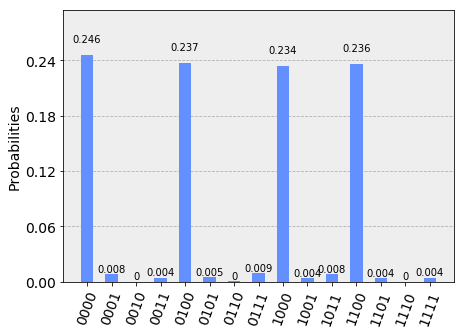

In [35]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=16384)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
plot_histogram(counts)

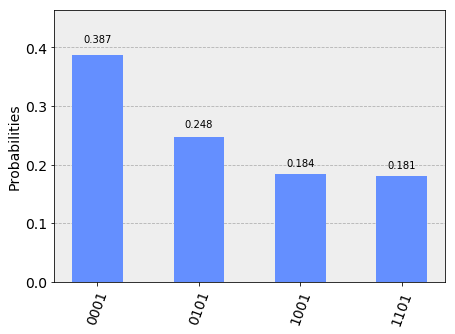

In [36]:
goodCounts = {k: counts[k] for k in counts.keys() & {'0001','0101','1001','1101'}}
plot_histogram(goodCounts)